# K리그 관중 수 예측 시각화

이 노트북은 `k_league_attendance_model.py`에서 생성한 결과 파일과 실제 2025 데이터를 비교 시각화합니다.

**사전 요구사항:**
1. `python k_league_attendance_model.py` 실행 완료
2. `results/` 폴더에 CSV 파일들이 생성되어 있어야 함

**생성되는 그래프:**
1. 피처 중요도 (Feature Importance)
2. 검증 성능 (Validation Performance)
3. **2025 시즌 실제 vs 예측 비교**
4. 2026 시즌 라운드별 예측
5. 2026 시즌 월별 트렌드
6. 더비 효과 분석
7. 요일별 관중 분석

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경로 설정
data_path = Path('data/')
results_path = Path('results/')
figures_path = results_path
figures_path.mkdir(exist_ok=True)

print('환경 설정 완료')

환경 설정 완료


## 1. 데이터 로드

In [ ]:
# 필요한 CSV 파일 로드
try:
    df_importance = pd.read_csv(results_path / '피처중요도.csv', encoding='utf-8-sig')
    df_performance = pd.read_csv(results_path / '모델성능.csv', encoding='utf-8-sig')
    df_validation = pd.read_csv(results_path / '검증데이터_예측결과.csv', encoding='utf-8-sig')
    df_2026 = pd.read_csv(results_path / '2026시즌_전체예측.csv', encoding='utf-8-sig')
    
    # 2025 실제 데이터 로드
    df_2025_actual = pd.read_csv(data_path / 'k_league1_2025.csv', encoding='utf-8-sig')
    
    # 날짜 컬럼 변환
    df_validation['날짜'] = pd.to_datetime(df_validation['날짜'])
    df_2026['날짜'] = pd.to_datetime(df_2026['날짜'])
    df_2025_actual['date'] = pd.to_datetime(df_2025_actual['date'])
    
    print('데이터 로드 완료')
    print(f'- 피처 중요도: {len(df_importance)}개')
    print(f'- 검증 데이터: {len(df_validation)}경기')
    print(f'- 2025 실제: {len(df_2025_actual)}경기')
    print(f'- 2026 예측: {len(df_2026)}경기')
    
except FileNotFoundError as e:
    print(f'오류: {e}')
    print('먼저 k_league_attendance_model.py를 실행하세요.')

데이터 로드 완료
  - 피처 중요도: 18개
  - 검증 데이터: 140경기
  - 2025 실제: 232경기
  - 2026 예측: 228경기


## 2. 그래프 1: 피처 중요도

저장: 01_feature_importance.png


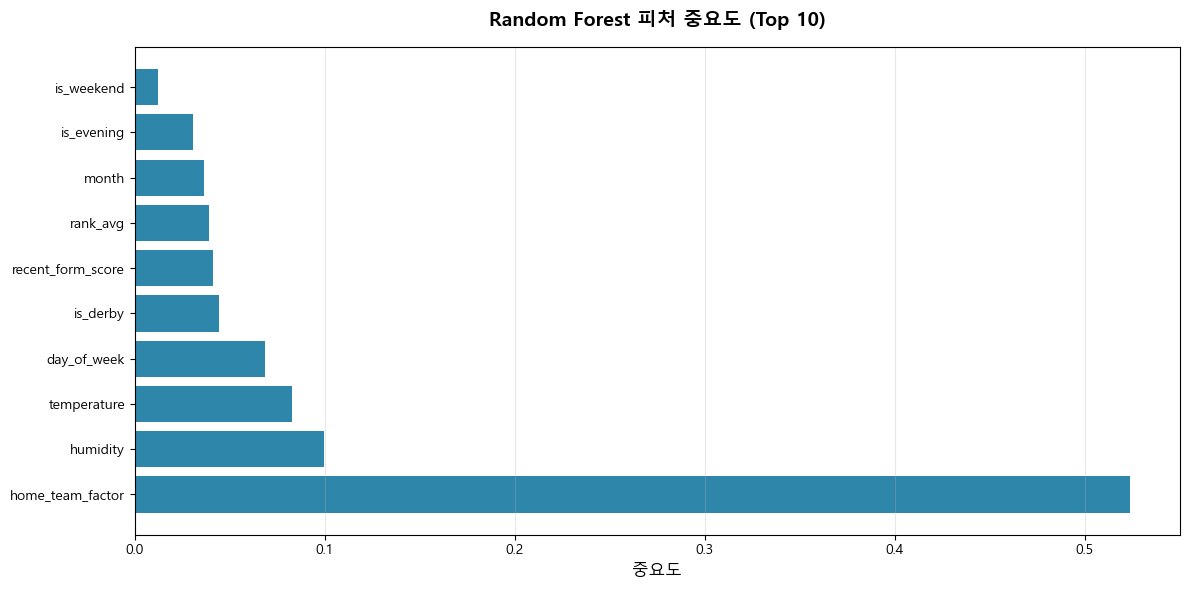

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

importances_plot = df_importance.head(10)
ax.barh(importances_plot['피처'], importances_plot['중요도'], color='#2E86AB')
ax.set_xlabel('중요도', fontsize=12)
ax.set_title('Random Forest 피처 중요도 (Top 10)', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(figures_path / '01_feature_importance.png', dpi=300, bbox_inches='tight')
print('저장: 01_feature_importance.png')
plt.show()

## 3. 그래프 2: 검증 성능 + 잔차 분석

저장: 02_validation_performance.png


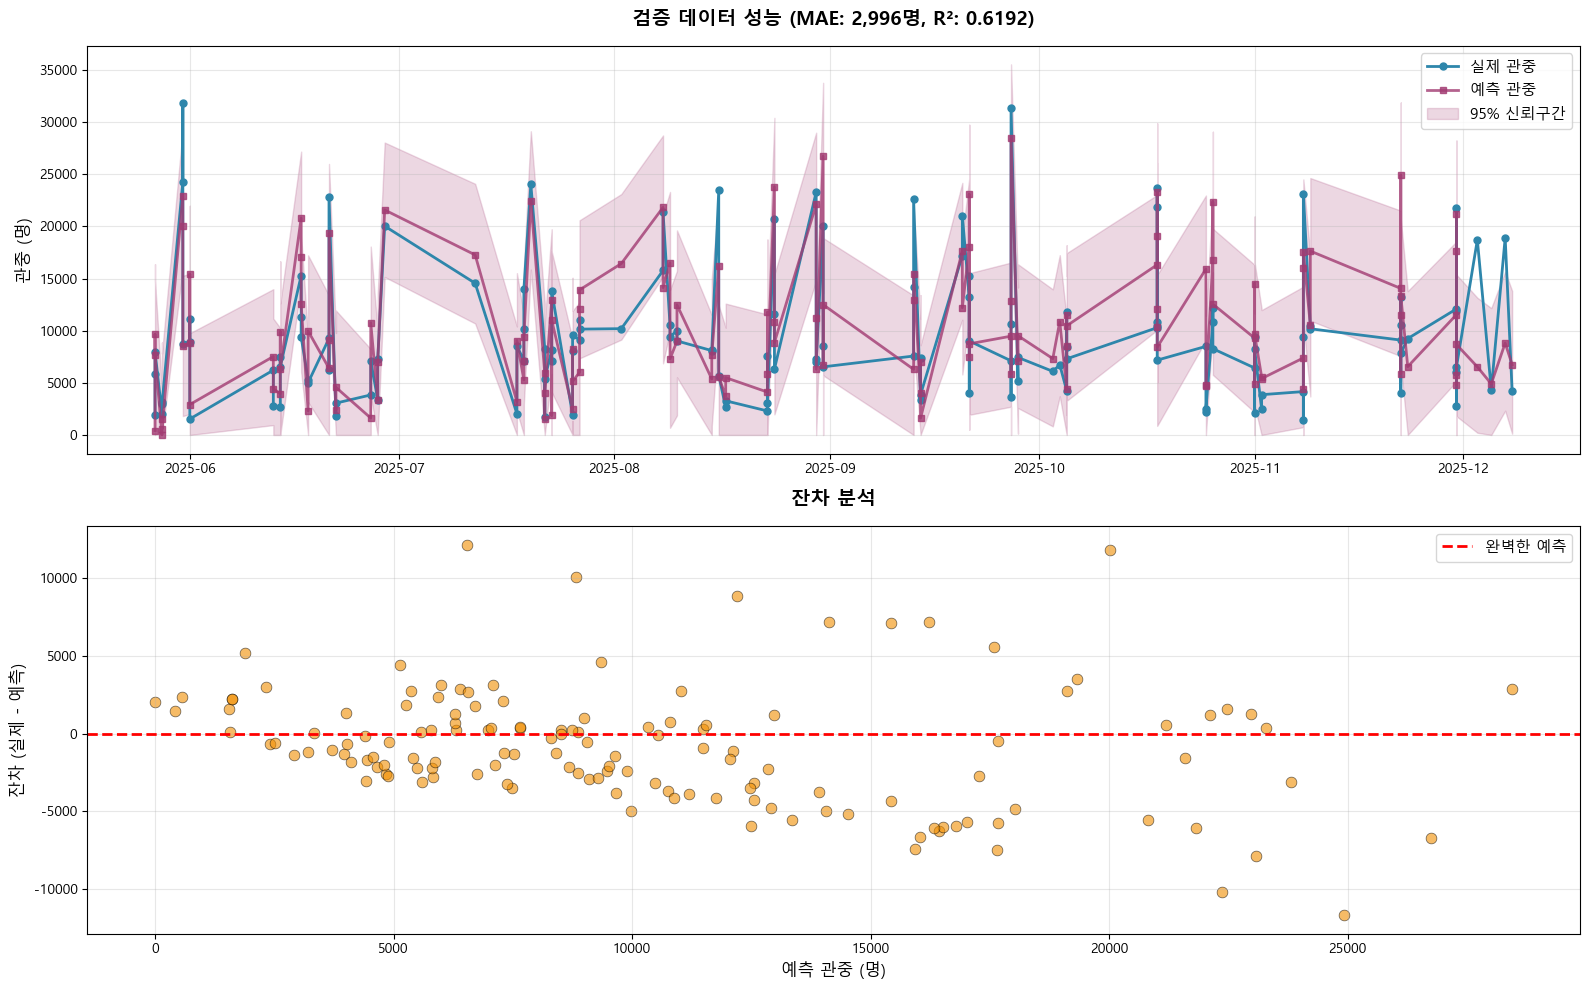

In [28]:
# 성능 지표 추출
mae = df_performance[df_performance['지표'] == 'MAE']['값'].values[0]
r2 = df_performance[df_performance['지표'] == 'R²']['값'].values[0]

# 그래프 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# 상단: 실제 vs 예측
ax1.plot(df_validation['날짜'], df_validation['실제관중'], 'o-', ms=5, 
         label='실제 관중', color='#2E86AB', lw=2)
ax1.plot(df_validation['날짜'], df_validation['예측관중'], 's-', ms=5, 
         label='예측 관중', color='#A23B72', lw=2, alpha=0.8)
ax1.fill_between(df_validation['날짜'], 
                  df_validation['하한95'], 
                  df_validation['상한95'],
                  alpha=0.2, color='#A23B72', label='95% 신뢰구간')
ax1.set_title(f'검증 데이터 성능 (MAE: {mae:,.0f}명, R²: {r2:.4f})',
              fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('관중 (명)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 하단: 잔차 분석
ax2.scatter(df_validation['예측관중'], df_validation['오차'], 
            alpha=0.6, s=60, color='#F18F01', edgecolors='black', lw=0.5)
ax2.axhline(0, color='red', ls='--', lw=2, label='완벽한 예측')
ax2.set_xlabel('예측 관중 (명)', fontsize=12)
ax2.set_ylabel('잔차 (실제 - 예측)', fontsize=12)
ax2.set_title('잔차 분석', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_path / '02_validation_performance.png', dpi=300, bbox_inches='tight')
print('저장: 02_validation_performance.png')
plt.show()

## 4. 그래프 3: 2025 시즌 실제 vs 예측 비교

2025 시즌의 **실제 관중**과 모델이 예측했을 **예측 관중**을 비교합니다.

2025 시즌 실제 데이터: 232경기
2025 시즌 검증 데이터: 140경기
 저장: 03_2025_actual_vs_predicted.png


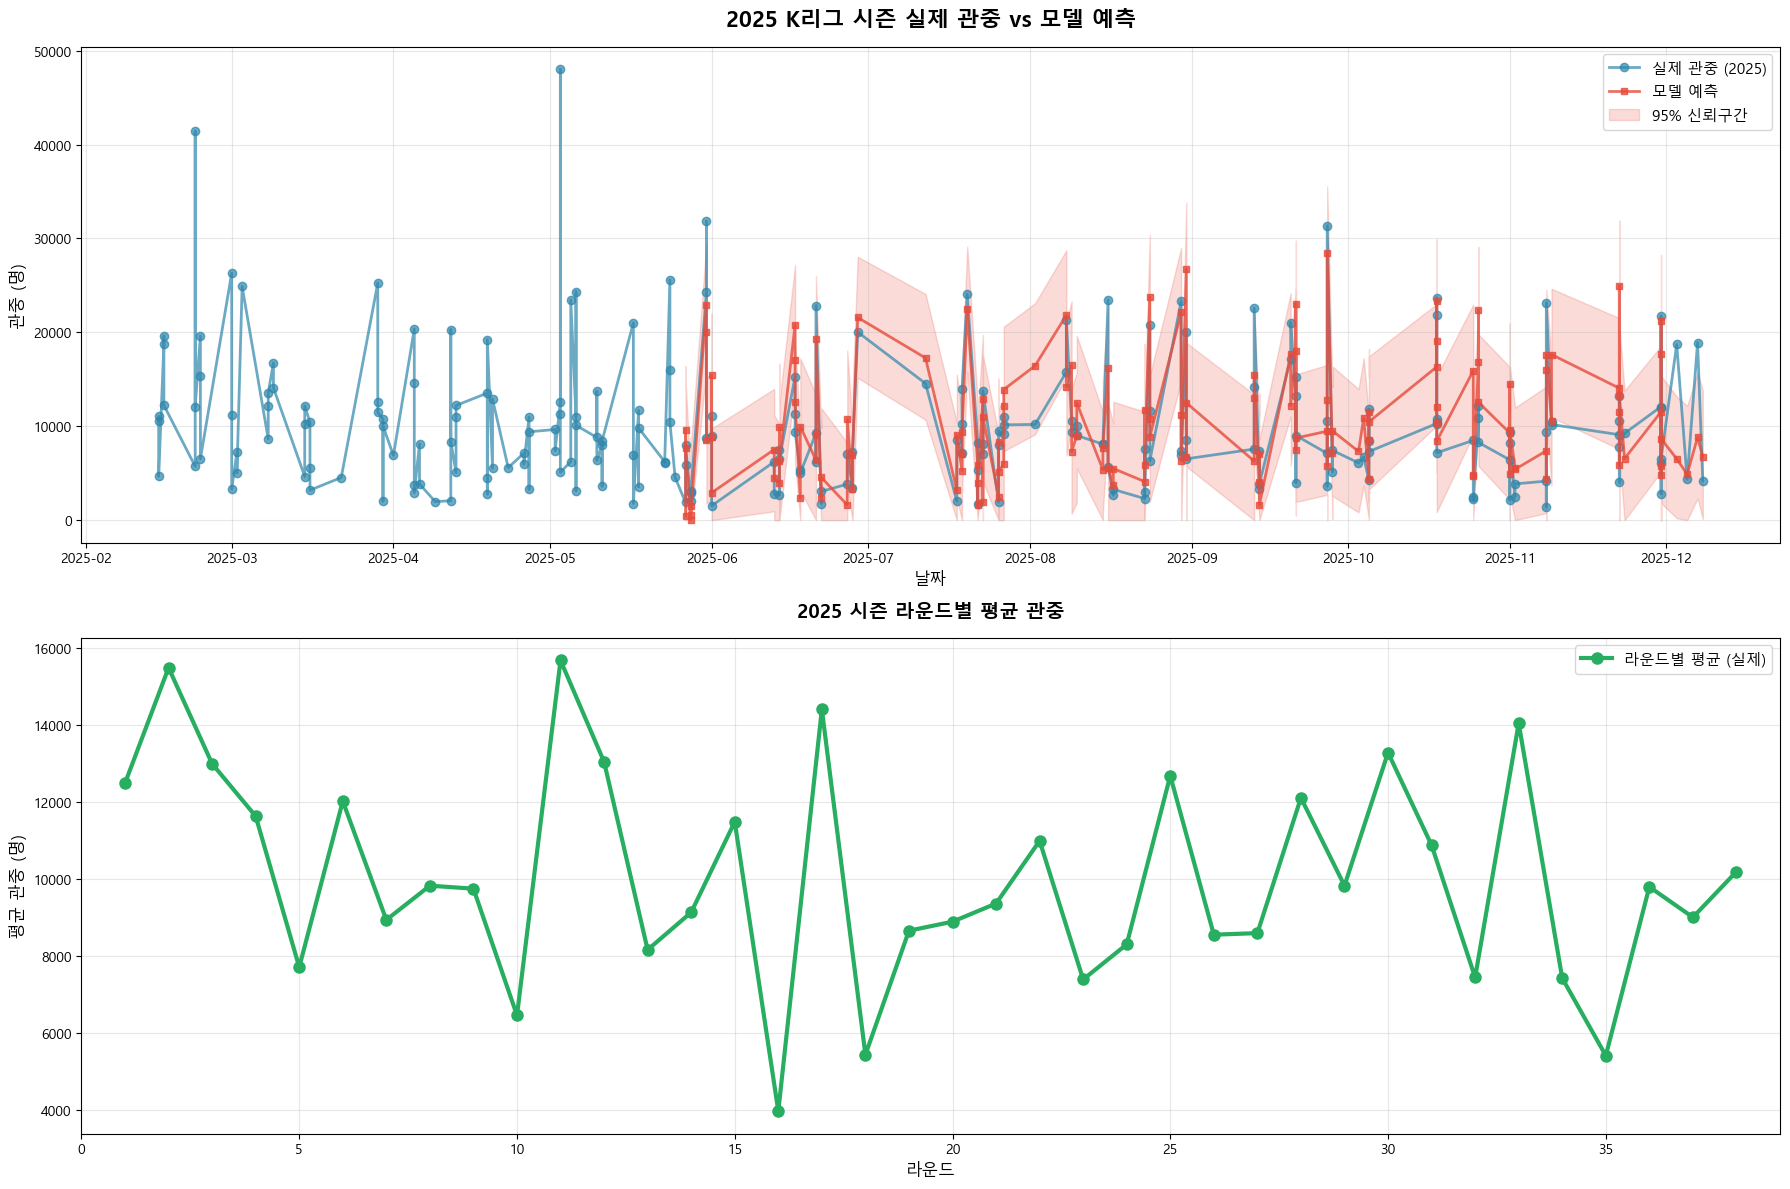


2025 시즌 통계:
  평균 관중: 10,107명
  최대 관중: 48,008명
  최소 관중: 1,405명


In [ ]:
# 2025 데이터 준비
df_2025 = df_2025_actual[['date', 'attendance', 'round']].copy()
df_2025 = df_2025.dropna(subset=['attendance'])
df_2025 = df_2025[df_2025['attendance'] >= 500]  # 이상치 제거

# 라운드별 평균 계산
round_2025_actual = df_2025.groupby('round')['attendance'].mean()

# 검증 데이터에서 2025년 데이터 추출
df_val_2025 = df_validation[df_validation['날짜'].dt.year == 2025].copy()

print(f'2025 시즌 실제 데이터: {len(df_2025)}경기')
print(f'2025 시즌 검증 데이터: {len(df_val_2025)}경기')

# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# 상단: 전체 시즌 추이
ax1.plot(df_2025['date'], df_2025['attendance'], 'o-', 
         ms=6, label='실제 관중 (2025)', color='#2E86AB', lw=2, alpha=0.7)

if len(df_val_2025) > 0:
    ax1.plot(df_val_2025['날짜'], df_val_2025['예측관중'], 's-', 
             ms=5, label='모델 예측', color='#E74C3C', lw=2, alpha=0.8)
    ax1.fill_between(df_val_2025['날짜'], 
                      df_val_2025['하한95'], 
                      df_val_2025['상한95'],
                      alpha=0.2, color='#E74C3C', label='95% 신뢰구간')

ax1.set_xlabel('날짜', fontsize=12)
ax1.set_ylabel('관중 (명)', fontsize=12)
ax1.set_title('2025 K리그 시즌 실제 관중 vs 모델 예측', 
              fontsize=16, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 하단: 라운드별 평균
if 'round' in df_2025.columns and len(round_2025_actual) > 0:
    rounds = round_2025_actual.index
    ax2.plot(rounds, round_2025_actual.values, 'o-', 
             lw=3, ms=8, color='#27AE60', label='라운드별 평균 (실제)')
    
    ax2.set_xlabel('라운드', fontsize=12)
    ax2.set_ylabel('평균 관중 (명)', fontsize=12)
    ax2.set_title('2025 시즌 라운드별 평균 관중', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, max(rounds) + 1)

plt.tight_layout()
plt.savefig(figures_path / '03_2025_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print(' 저장: 03_2025_actual_vs_predicted.png')
plt.show()

# 2025 시즌 통계
print(f'\n2025 시즌 통계:')
print(f'평균 관중: {df_2025["attendance"].mean():,.0f}명')
print(f'최대 관중: {df_2025["attendance"].max():,.0f}명')
print(f'최소 관중: {df_2025["attendance"].min():,.0f}명')

## 5. 그래프 4: 2026 시즌 라운드별 예측

저장: 04_season_2026_by_round.png


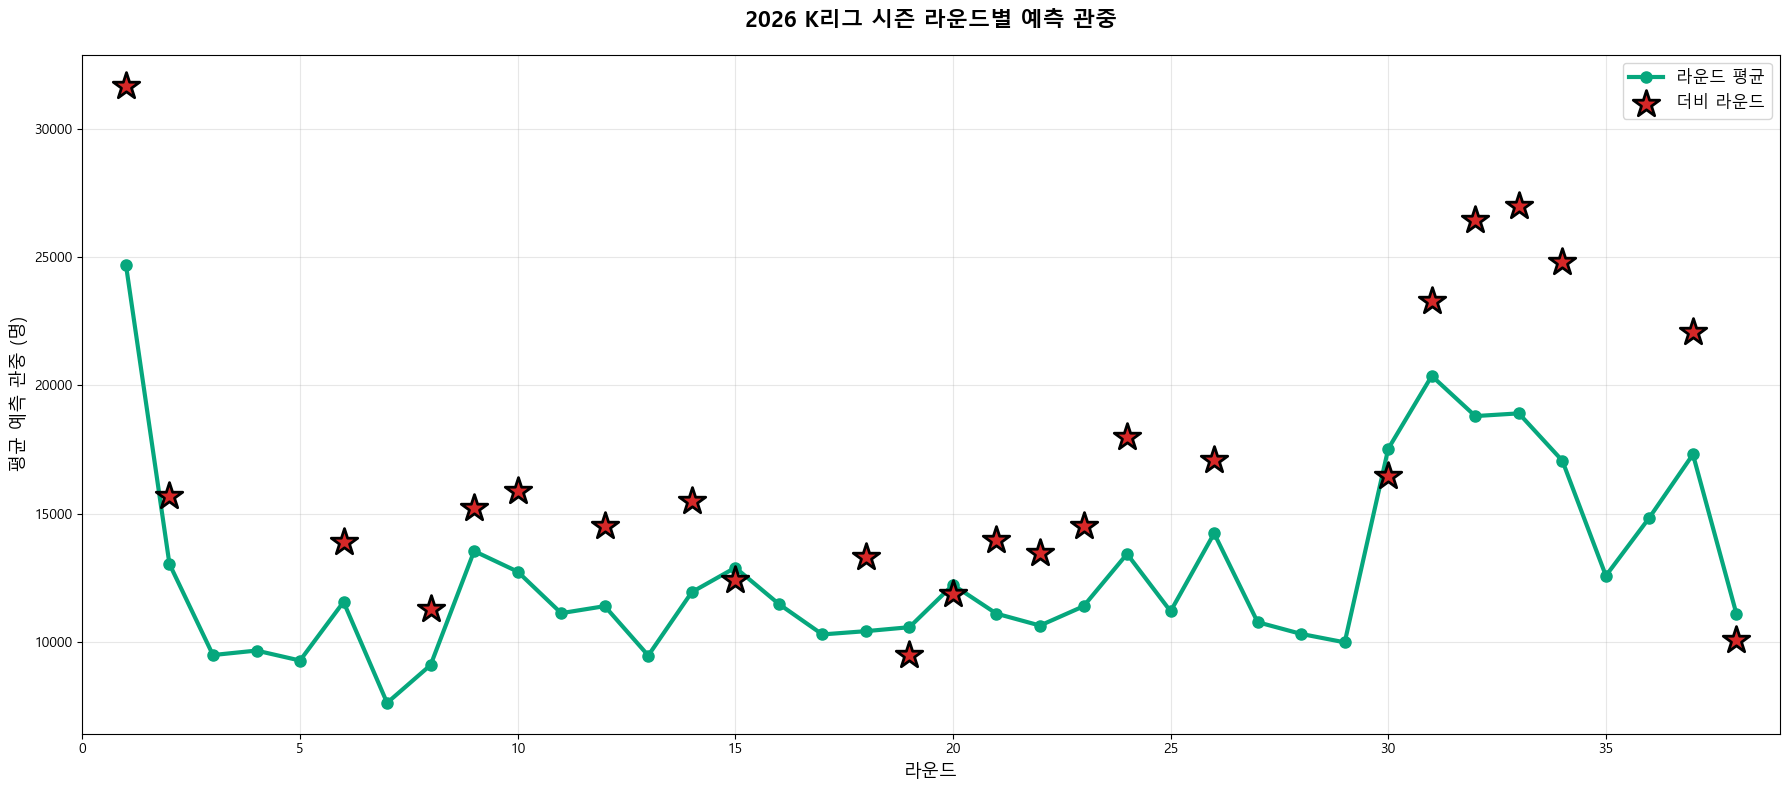

In [ ]:
# 라운드별 평균 계산
if '라운드' in df_2026.columns:
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # 라운드별 평균
    round_avg = df_2026.groupby('라운드')['예측관중'].mean()
    ax.plot(round_avg.index, round_avg.values, 'o-', lw=3, ms=8, 
            color='#06A77D', label='라운드 평균')
    
    # 더비 라운드 강조
    derby_data = df_2026[df_2026['더비'] == '더비']
    if len(derby_data) > 0:
        derby_avg = derby_data.groupby('라운드')['예측관중'].mean()
        ax.scatter(derby_avg.index, derby_avg.values, s=400, marker='*',
                  color='#D62828', edgecolors='black', lw=2, 
                  label='더비 라운드', zorder=10)
    
    ax.set_xlabel('라운드', fontsize=13)
    ax.set_ylabel('평균 예측 관중 (명)', fontsize=13)
    ax.set_title('2026 K리그 시즌 라운드별 예측 관중', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, df_2026['라운드'].max() + 1)
    
    plt.tight_layout()
    plt.savefig(figures_path / '04_season_2026_by_round.png', 
                dpi=300, bbox_inches='tight')
    print('저장: 04_season_2026_by_round.png')
    plt.show()
else:
    print('라운드 정보 없음 - 라운드별 그래프 생략')

## 6. 그래프 5: 2026 시즌 월별 트렌드

저장: 05_season_2026_monthly.png


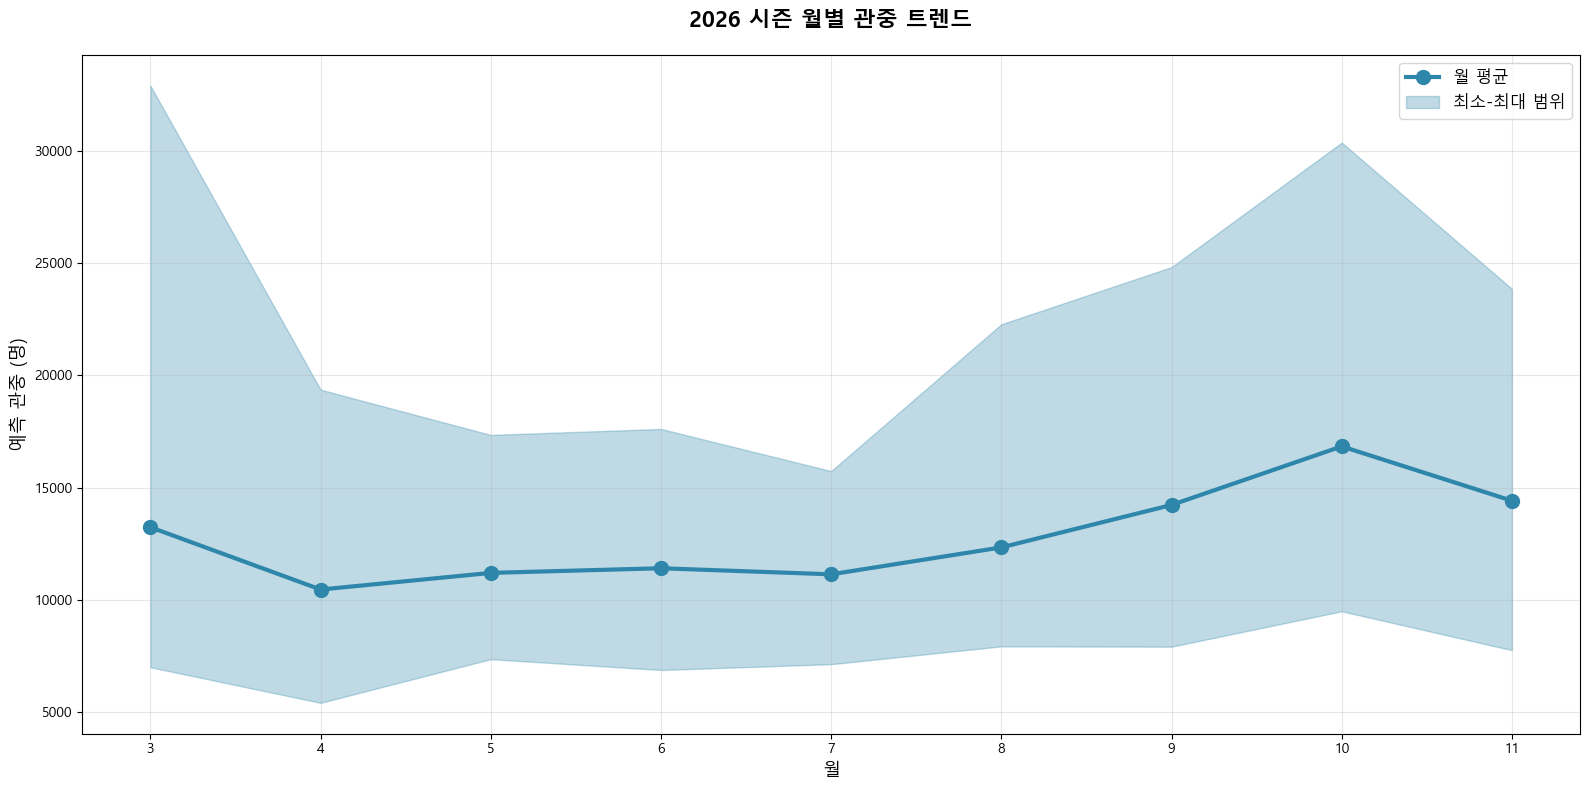

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))

# 월별 통계
monthly_avg = df_2026.groupby(df_2026['날짜'].dt.month).agg({
    '예측관중': ['mean', 'min', 'max']
}).reset_index()
monthly_avg.columns = ['month', 'mean', 'min', 'max']

ax.plot(monthly_avg['month'], monthly_avg['mean'], 'o-', 
        lw=3, ms=10, color='#2E86AB', label='월 평균')
ax.fill_between(monthly_avg['month'], monthly_avg['min'], monthly_avg['max'],
                alpha=0.3, color='#2E86AB', label='최소-최대 범위')

ax.set_xlabel('월', fontsize=13)
ax.set_ylabel('예측 관중 (명)', fontsize=13)
ax.set_title('2026 시즌 월별 관중 트렌드', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(sorted(df_2026['날짜'].dt.month.unique()))

plt.tight_layout()
plt.savefig(figures_path / '05_season_2026_monthly.png', dpi=300, bbox_inches='tight')
print('저장: 05_season_2026_monthly.png')
plt.show()

## 7. 그래프 6: 더비 효과 분석

저장: 06_derby_effect.png


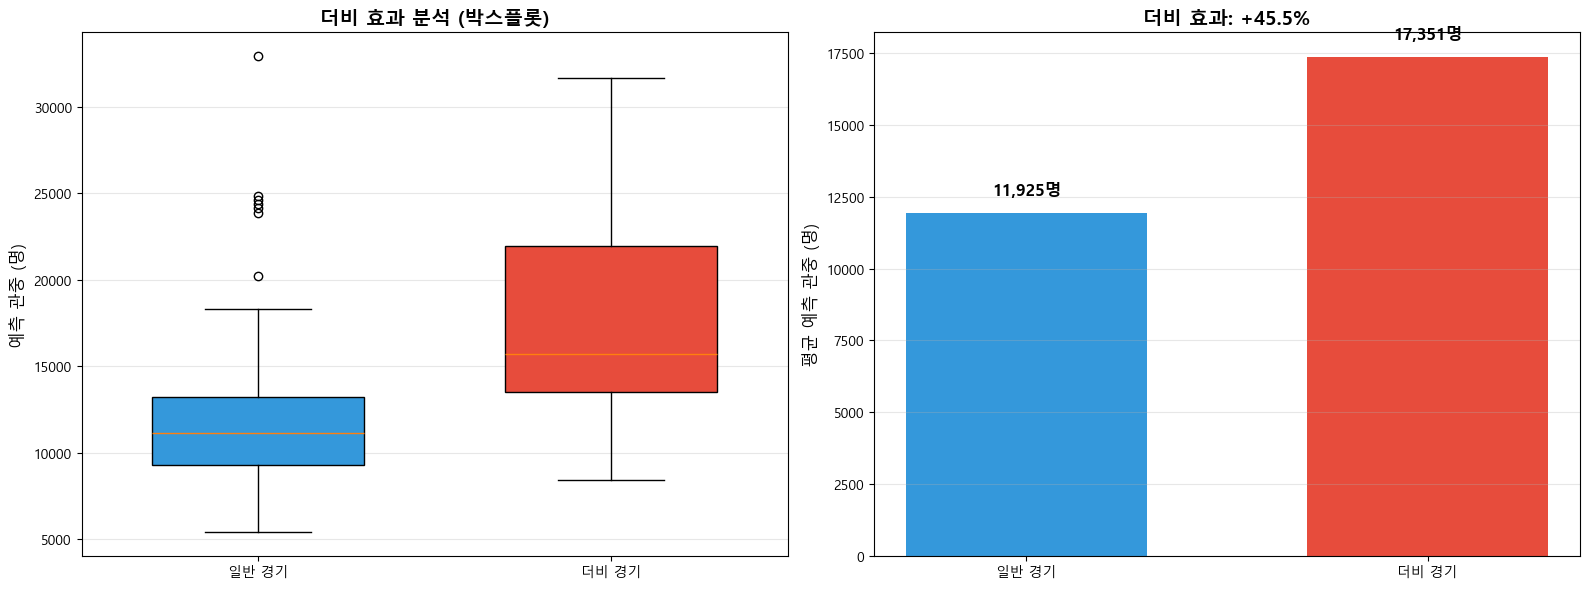

In [32]:
# 더비 vs 일반 경기 비교
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 좌측: 박스플롯
derby_data = [df_2026[df_2026['더비'] == '일반']['예측관중'],
              df_2026[df_2026['더비'] == '더비']['예측관중']]
bp = ax1.boxplot(derby_data, labels=['일반 경기', '더비 경기'],
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
ax1.set_ylabel('예측 관중 (명)', fontsize=12)
ax1.set_title('더비 효과 분석 (박스플롯)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 우측: 막대 그래프
derby_avg = df_2026[df_2026['더비'] == '더비']['예측관중'].mean()
normal_avg = df_2026[df_2026['더비'] == '일반']['예측관중'].mean()
derby_effect = ((derby_avg / normal_avg - 1) * 100)

bars = ax2.bar(['일반 경기', '더비 경기'], [normal_avg, derby_avg],
               color=['#3498db', '#e74c3c'], width=0.6)
ax2.set_ylabel('평균 예측 관중 (명)', fontsize=12)
ax2.set_title(f'더비 효과: +{derby_effect:.1f}%', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, val in zip(bars, [normal_avg, derby_avg]):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 500,
             f'{val:,.0f}명', ha='center', va='bottom',
             fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(figures_path / '06_derby_effect.png', dpi=300, bbox_inches='tight')
print('저장: 06_derby_effect.png')
plt.show()

## 8. 그래프 7: 요일별 관중 분석

 저장: 07_weekday_analysis.png


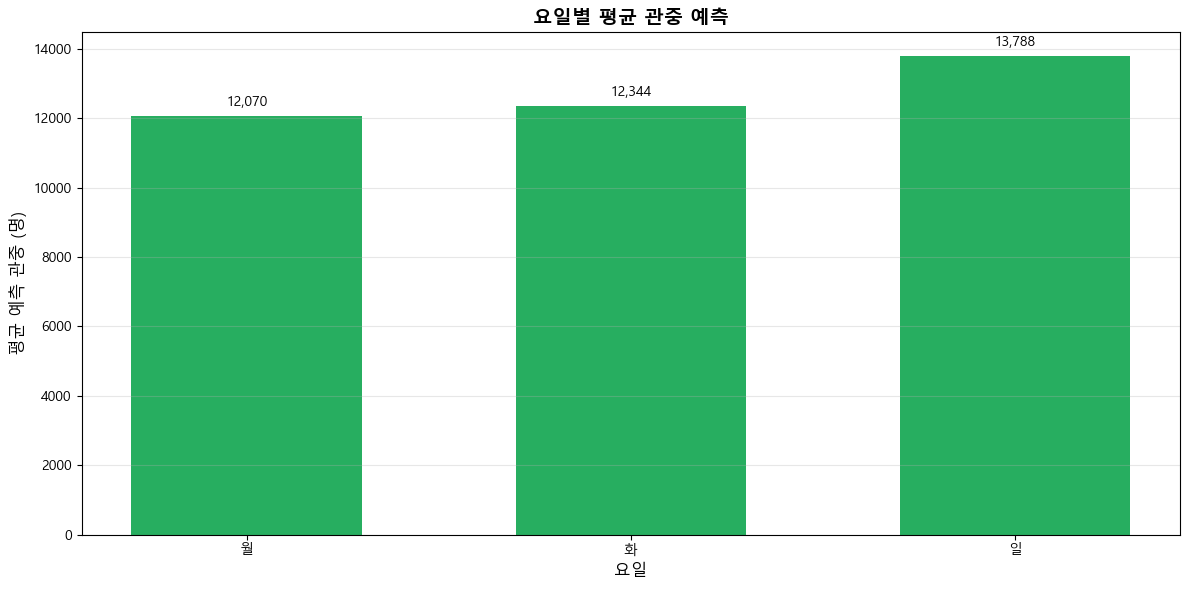


경기가 없는 요일: 수, 목, 금, 토


In [ ]:
# 요일별 관중 분석
if '요일' in df_2026.columns:
    # 요일 순서 정의
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                     'Friday', 'Saturday', 'Sunday']
    weekday_korean = ['월', '화', '수', '목', '금', '토', '일']
    
    # 요일별 평균 계산
    weekday_avg = df_2026.groupby('요일')['예측관중'].mean()
    
    # 실제 경기가 있는 요일만 필터링
    available_weekdays = []
    available_korean = []
    available_values = []
    
    for eng, kor in zip(weekday_order, weekday_korean):
        if eng in weekday_avg.index and weekday_avg[eng] > 0:
            available_weekdays.append(eng)
            available_korean.append(kor)
            available_values.append(weekday_avg[eng])
    
    if len(available_values) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        bars = ax.bar(available_korean, available_values, color='#27AE60', width=0.6)
        ax.set_xlabel('요일', fontsize=12)
        ax.set_ylabel('평균 예측 관중 (명)', fontsize=12)
        ax.set_title('요일별 평균 관중 예측', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for bar, val in zip(bars, available_values):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200,
                    f'{val:,.0f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(figures_path / '07_weekday_analysis.png', dpi=300, bbox_inches='tight')
        print(' 저장: 07_weekday_analysis.png')
        plt.show()
        
        # 경기 없는 요일 안내
        missing_weekdays = [kor for eng, kor in zip(weekday_order, weekday_korean) 
                           if eng not in available_weekdays]
        if missing_weekdays:
            print(f'\n경기가 없는 요일: {", ".join(missing_weekdays)}')
    else:
        print('요일별 데이터 없음')
else:
    print('요일 정보 없음 - 요일별 그래프 생략')

## 9. 요약 통계

## 10. 그래프 8: 2026 시즌 실제 vs 예측 비교 (실제 데이터 있을 때)

**2026 시즌 실제 데이터가 발표되면 자동으로 비교 그래프를 생성합니다.**

In [ ]:
# 2026 실제 데이터 확인
data_2026_file = data_path / "k_league1_2026.csv"

if data_2026_file.exists():
    print("2026 실제 데이터 발견!")
    
    # 실제 데이터 로드
    df_2026_actual = pd.read_csv(data_2026_file, encoding="utf-8-sig")
    df_2026_actual["date"] = pd.to_datetime(df_2026_actual["date"])
    df_2026_actual_clean = df_2026_actual[["date", "attendance", "round"]].copy()
    df_2026_actual_clean = df_2026_actual_clean.dropna(subset=["attendance"])
    df_2026_actual_clean = df_2026_actual_clean[df_2026_actual_clean["attendance"] >= 500]
    
    actual_count = len(df_2026_actual_clean)
    pred_count = len(df_2026)
    print(f"  실제 경기 수: {actual_count}경기")
    print(f"  예측 경기 수: {pred_count}경기")
    
    # 시각화
    fig, axes = plt.subplots(3, 1, figsize=(18, 16))
    
    # 그래프 1: 시계열 비교
    ax1 = axes[0]
    ax1.plot(df_2026_actual_clean["date"], df_2026_actual_clean["attendance"], 
             "o-", ms=6, label="실제 관중 (2026)", color="#2E86AB", lw=2, alpha=0.7)
    ax1.plot(df_2026["날짜"], df_2026["예측관중"], 
             "s-", ms=5, label="모델 예측", color="#E74C3C", lw=2, alpha=0.8)
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("관중 (명)", fontsize=12)
    ax1.set_title("2026 K리그 시즌 실제 관중 vs 모델 예측", 
                  fontsize=16, fontweight="bold", pad=15)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 그래프 2: 라운드별 비교
    ax2 = axes[1]
    if "round" in df_2026_actual_clean.columns and "라운드" in df_2026.columns:
        round_actual = df_2026_actual_clean.groupby("round")["attendance"].mean()
        round_pred = df_2026.groupby("라운드")["예측관중"].mean()
        
        ax2.plot(round_actual.index, round_actual.values, "o-", 
                 lw=3, ms=8, color="#27AE60", label="실제 (라운드별 평균)")
        ax2.plot(round_pred.index, round_pred.values, "s-", 
                 lw=3, ms=8, color="#E74C3C", label="예측 (라운드별 평균)")
        
        ax2.set_xlabel("라운드", fontsize=12)
        ax2.set_ylabel("평균 관중 (명)", fontsize=12)
        ax2.set_title("2026 시즌 라운드별 실제 vs 예측", 
                      fontsize=14, fontweight="bold", pad=15)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        max_round = max(round_actual.index.max(), round_pred.index.max())
        ax2.set_xlim(0, max_round + 1)
    
    # 그래프 3: 오차 분석
    ax3 = axes[2]
    
    # 날짜 기준으로 매칭
    min_len = min(len(df_2026_actual_clean), len(df_2026))
    actual_vals = df_2026_actual_clean["attendance"].values[:min_len]
    pred_vals = df_2026["예측관중"].values[:min_len]
    errors = actual_vals - pred_vals
    
    ax3.scatter(pred_vals, errors, alpha=0.6, s=60, 
                color="#F18F01", edgecolors="black", lw=0.5)
    ax3.axhline(0, color="red", ls="--", lw=2, label="완벽한 예측")
    ax3.set_xlabel("예측 관중 (명)", fontsize=12)
    ax3.set_ylabel("오차 (실제 - 예측)", fontsize=12)
    ax3.set_title("2026 예측 오차 분석", fontsize=14, fontweight="bold", pad=15)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_path / "08_2026_actual_vs_predicted.png", dpi=300, bbox_inches="tight")
    print("저장: 08_2026_actual_vs_predicted.png")
    plt.show()
    
    # 성능 지표 계산
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae_2026 = mean_absolute_error(actual_vals, pred_vals)
    rmse_2026 = np.sqrt(mean_squared_error(actual_vals, pred_vals))
    r2_2026 = r2_score(actual_vals, pred_vals)
    
    print("2026 시즌 예측 성능:")
    print(f"MAE:  {mae_2026:,.0f}명")
    print(f"RMSE: {rmse_2026:,.0f}명")
    print(f"R2:   {r2_2026:.4f}")
    print("2026 실제 통계:")
    avg_att = df_2026_actual_clean["attendance"].mean()
    max_att = df_2026_actual_clean["attendance"].max()
    min_att = df_2026_actual_clean["attendance"].min()
    print(f"평균 관중: {avg_att:,.0f}명")
    print(f"최대 관중: {max_att:,.0f}명")
    print(f"최소 관중: {min_att:,.0f}명")
    
else:
    print("2026 실제 데이터 없음")
    print("2026 시즌이 진행되면 data/k_league1_2026.csv 파일을 추가하세요")
    print("그러면 자동으로 실제 vs 예측 비교 그래프가 생성됩니다!")

2026 실제 데이터 없음
2026 시즌이 진행되면 data/k_league1_2026.csv 파일을 추가하세요
그러면 자동으로 실제 vs 예측 비교 그래프가 생성됩니다!


## 10. 그래프 8: 2026 시즌 실제 vs 예측 비교 (실제 데이터 있을 때)

**2026 시즌 실제 데이터가 발표되면 자동으로 비교 그래프를 생성합니다.**

In [ ]:
# 2026 실제 데이터 확인
data_2026_file = data_path / "k_league1_2026.csv"

if data_2026_file.exists():
    print("2026 실제 데이터 발견!")
    
    # 실제 데이터 로드
    df_2026_actual = pd.read_csv(data_2026_file, encoding="utf-8-sig")
    df_2026_actual["date"] = pd.to_datetime(df_2026_actual["date"])
    df_2026_actual_clean = df_2026_actual[["date", "attendance", "round"]].copy()
    df_2026_actual_clean = df_2026_actual_clean.dropna(subset=["attendance"])
    df_2026_actual_clean = df_2026_actual_clean[df_2026_actual_clean["attendance"] >= 500]
    
    print(f"실제 경기 수: {len(df_2026_actual_clean)}경기")
    print(f"예측 경기 수: {len(df_2026)}경기")
    
    # 시각화
    fig, axes = plt.subplots(3, 1, figsize=(18, 16))
    
    # 그래프 1: 시계열 비교
    ax1 = axes[0]
    ax1.plot(df_2026_actual_clean["date"], df_2026_actual_clean["attendance"], 
             "o-", ms=6, label="실제 관중 (2026)", color="#2E86AB", lw=2, alpha=0.7)
    ax1.plot(df_2026["날짜"], df_2026["예측관중"], 
             "s-", ms=5, label="모델 예측", color="#E74C3C", lw=2, alpha=0.8)
    ax1.set_xlabel("날짜", fontsize=12)
    ax1.set_ylabel("관중 (명)", fontsize=12)
    ax1.set_title("2026 K리그 시즌 실제 관중 vs 모델 예측", 
                  fontsize=16, fontweight="bold", pad=15)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 그래프 2: 라운드별 비교
    ax2 = axes[1]
    if "round" in df_2026_actual_clean.columns and "라운드" in df_2026.columns:
        round_actual = df_2026_actual_clean.groupby("round")["attendance"].mean()
        round_pred = df_2026.groupby("라운드")["예측관중"].mean()
        
        ax2.plot(round_actual.index, round_actual.values, "o-", 
                 lw=3, ms=8, color="#27AE60", label="실제 (라운드별 평균)")
        ax2.plot(round_pred.index, round_pred.values, "s-", 
                 lw=3, ms=8, color="#E74C3C", label="예측 (라운드별 평균)")
        
        ax2.set_xlabel("라운드", fontsize=12)
        ax2.set_ylabel("평균 관중 (명)", fontsize=12)
        ax2.set_title("2026 시즌 라운드별 실제 vs 예측", 
                      fontsize=14, fontweight="bold", pad=15)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, max(round_actual.index.max(), round_pred.index.max()) + 1)
    
    # 그래프 3: 오차 분석
    ax3 = axes[2]
    
    # 날짜 기준으로 매칭 (간단한 방법: 순서대로 매칭)
    min_len = min(len(df_2026_actual_clean), len(df_2026))
    actual_vals = df_2026_actual_clean["attendance"].values[:min_len]
    pred_vals = df_2026["예측관중"].values[:min_len]
    errors = actual_vals - pred_vals
    
    ax3.scatter(pred_vals, errors, alpha=0.6, s=60, 
                color="#F18F01", edgecolors="black", lw=0.5)
    ax3.axhline(0, color="red", ls="--", lw=2, label="완벽한 예측")
    ax3.set_xlabel("예측 관중 (명)", fontsize=12)
    ax3.set_ylabel("오차 (실제 - 예측)", fontsize=12)
    ax3.set_title("2026 예측 오차 분석", fontsize=14, fontweight="bold", pad=15)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_path / "08_2026_actual_vs_predicted.png", dpi=300, bbox_inches="tight")
    print("저장: 08_2026_actual_vs_predicted.png")
    plt.show()
    
    # 성능 지표 계산
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae_2026 = mean_absolute_error(actual_vals, pred_vals)
    rmse_2026 = np.sqrt(mean_squared_error(actual_vals, pred_vals))
    r2_2026 = r2_score(actual_vals, pred_vals)
    
    print(f"\n2026 시즌 예측 성능:")
    print(f"MAE:  {mae_2026:,.0f}명")
    print(f"RMSE: {rmse_2026:,.0f}명")
    print(f"R²:   {r2_2026:.4f}")
    print(f"\n2026 실제 통계:")
    print(f'평균 관중: {df_2026_actual_clean["attendance"].mean():,.0f}명')
    print(f'최대 관중: {df_2026_actual_clean["attendance"].max():,.0f}명')
    print(f'최소 관중: {df_2026_actual_clean["attendance"].min():,.0f}명')
    
else:
    print("2026 실제 데이터 없음")
    print("2026 시즌이 진행되면 data/k_league1_2026.csv 파일을 추가하세요")
    print("그러면 자동으로 실제 vs 예측 비교 그래프가 생성됩니다!")

2026 실제 데이터 없음
2026 시즌이 진행되면 data/k_league1_2026.csv 파일을 추가하세요
그러면 자동으로 실제 vs 예측 비교 그래프가 생성됩니다!


## 9. 그래프 8-9: 상관관계 분석

주요 변수 간 상관관계를 히트맵과 산점도로 시각화합니다.

In [36]:
# 원본 데이터 로드 및 피처 생성
years = [2022, 2023, 2024, 2025]
dfs_raw = []
for year in years:
    df = pd.read_csv(data_path / f"k_league1_{year}.csv", encoding="utf-8-sig")
    dfs_raw.append(df)

df_all = pd.concat(dfs_raw, ignore_index=True)
df_all["date"] = pd.to_datetime(df_all["date"])
df_all["attendance"] = pd.to_numeric(df_all["attendance"], errors="coerce")

# 숫자형 변수 변환
for col in ["temperature", "humidity", "is_weekend", "is_derby"]:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

df_all["month"] = df_all["date"].dt.month
df_all["day_of_week"] = df_all["date"].dt.dayofweek

# 팀별 평균 관중 (home_team_factor)
team_avg = df_all.groupby("home_team")["attendance"].mean().to_dict()
overall_avg = df_all["attendance"].mean()
df_all["home_team_factor"] = df_all["home_team"].map(team_avg) / overall_avg
df_all["home_team_factor"] = df_all["home_team_factor"].fillna(1.0)

# 순위 피처
for col in ["home_rank_before", "away_rank_before"]:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

if "home_rank_before" in df_all.columns and "away_rank_before" in df_all.columns:
    df_all["rank_avg"] = (df_all["home_rank_before"] + df_all["away_rank_before"]) / 2
    df_all["rank_avg"] = df_all["rank_avg"].fillna(6.5)
else:
    df_all["rank_avg"] = 6.5

# 이상치 제거
df_clean = df_all[df_all["attendance"] >= 500].copy()

# 상관관계 분석용 변수 선택
corr_vars = ["attendance", "home_team_factor", "is_derby", "is_weekend",
             "humidity", "temperature", "rank_avg", "month", "day_of_week"]

df_corr = df_clean[corr_vars].dropna()
correlation_matrix = df_corr.corr()

print(f"상관관계 분석 데이터: {df_corr.shape}")
print(f"\n관중과의 상관계수:")
attendance_corr = correlation_matrix["attendance"].sort_values(ascending=False)
for var, corr in attendance_corr.items():
    if var != "attendance":
        print(f"  {var:20s}: {corr:>6.3f}")

상관관계 분석 데이터: (927, 9)

관중과의 상관계수:
  home_team_factor    :  0.695
  is_derby            :  0.283
  is_weekend          :  0.212
  day_of_week         :  0.200
  month               :  0.031
  humidity            :  0.002
  temperature         : -0.059
  rank_avg            : -0.128


저장: 08_correlation_heatmap.png


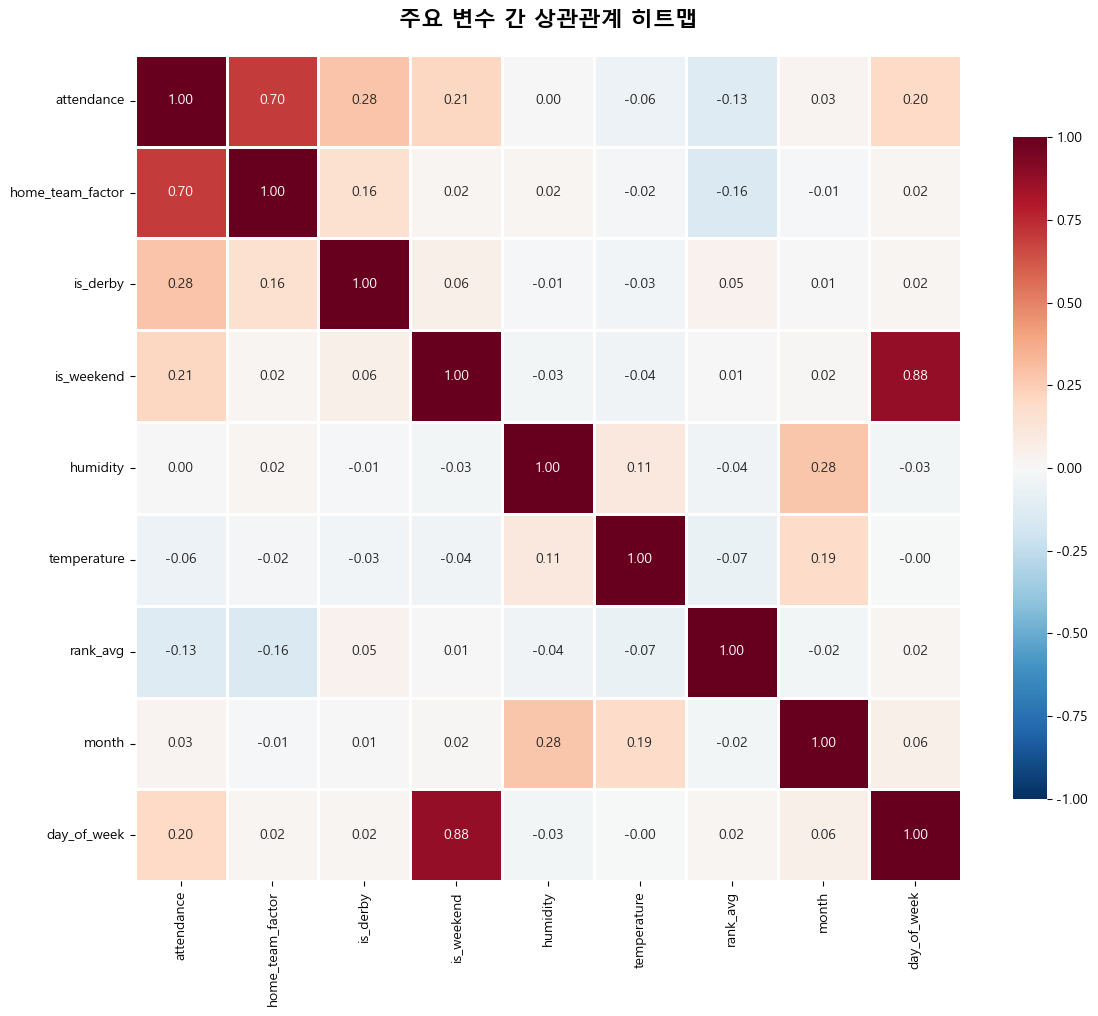

In [37]:
# 그래프 8: 상관관계 히트맵
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title("주요 변수 간 상관관계 히트맵", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig(figures_path / "08_correlation_heatmap.png", dpi=300, bbox_inches="tight")
print("저장: 08_correlation_heatmap.png")
plt.show()

저장: 09_scatter_plots.png


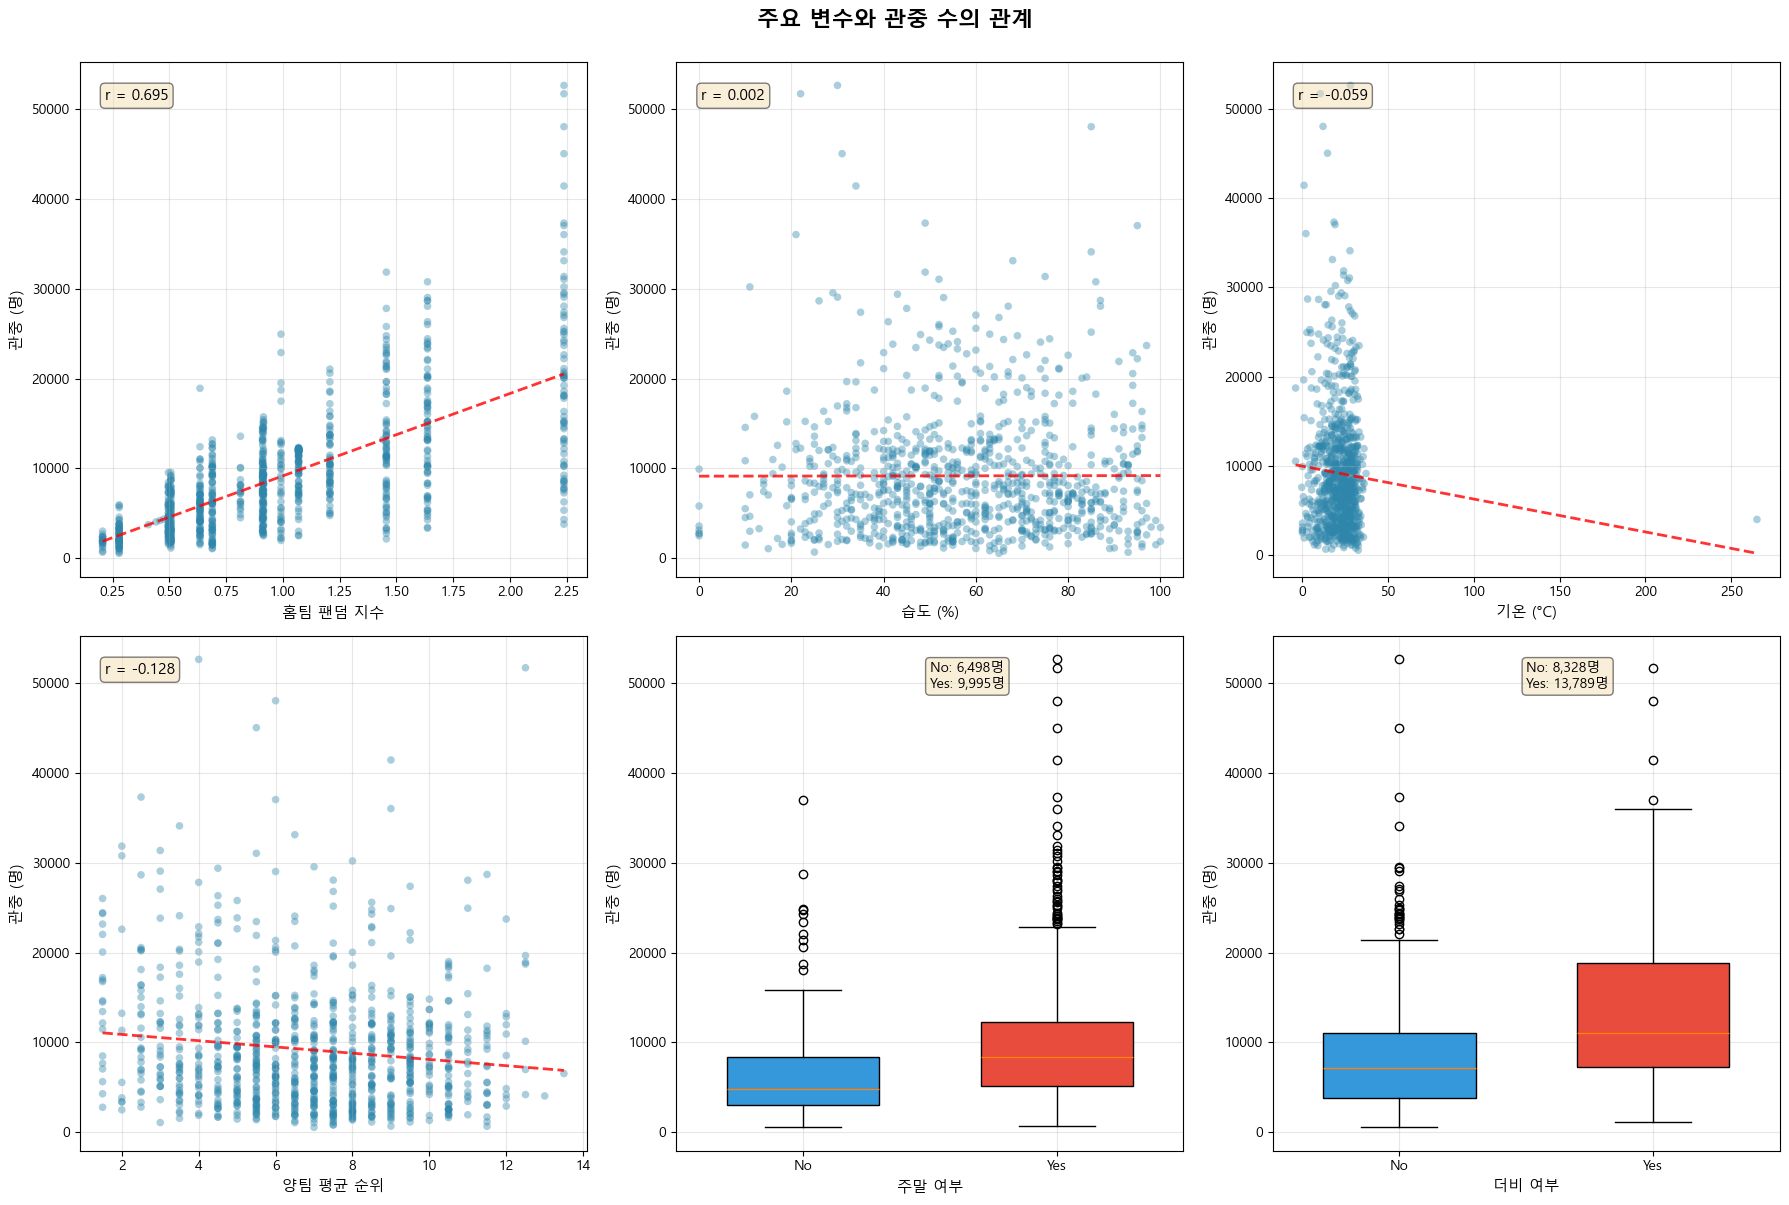

In [38]:
# 그래프 9: 주요 변수 산점도
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

scatter_vars = [
    ("home_team_factor", "홈팀 팬덤 지수"),
    ("humidity", "습도 (%)"),
    ("temperature", "기온 (°C)"),
    ("rank_avg", "양팀 평균 순위"),
    ("is_weekend", "주말 여부"),
    ("is_derby", "더비 여부")
]

for idx, (var, title) in enumerate(scatter_vars):
    ax = axes[idx]
    
    if var in ["is_weekend", "is_derby"]:
        # 카테고리형: 박스플롯
        data_0 = df_corr[df_corr[var] == 0]["attendance"]
        data_1 = df_corr[df_corr[var] == 1]["attendance"]
        
        bp = ax.boxplot([data_0, data_1], tick_labels=["No", "Yes"],
                        patch_artist=True, widths=0.6)
        bp["boxes"][0].set_facecolor("#3498db")
        bp["boxes"][1].set_facecolor("#e74c3c")
        
        ax.set_xlabel(title, fontsize=11)
        ax.set_ylabel("관중 (명)", fontsize=11)
        
        # 평균값 표시
        avg_0 = data_0.mean()
        avg_1 = data_1.mean()
        ax.text(0.5, 0.95, f"No: {avg_0:,.0f}명\nYes: {avg_1:,.0f}명",
                transform=ax.transAxes, fontsize=10,
                verticalalignment="top", bbox=dict(boxstyle="round",
                facecolor="wheat", alpha=0.5))
    else:
        # 연속형: 산점도 + 추세선
        ax.scatter(df_corr[var], df_corr["attendance"],
                  alpha=0.4, s=30, color="#2E86AB", edgecolors="none")
        
        # 추세선
        valid_idx = df_corr[var].notna()
        z = np.polyfit(df_corr.loc[valid_idx, var],
                      df_corr.loc[valid_idx, "attendance"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_corr[var].min(), df_corr[var].max(), 100)
        ax.plot(x_line, p(x_line), "r--", lw=2, alpha=0.8)
        
        ax.set_xlabel(title, fontsize=11)
        ax.set_ylabel("관중 (명)", fontsize=11)
        
        # 상관계수 표시
        corr_val = correlation_matrix.loc["attendance", var]
        ax.text(0.05, 0.95, f"r = {corr_val:.3f}",
                transform=ax.transAxes, fontsize=11,
                verticalalignment="top", bbox=dict(boxstyle="round",
                facecolor="wheat", alpha=0.5))
    
    ax.grid(True, alpha=0.3)

plt.suptitle("주요 변수와 관중 수의 관계", fontsize=16, fontweight="bold", y=1.00)
plt.tight_layout()
plt.savefig(figures_path / "09_scatter_plots.png", dpi=300, bbox_inches="tight")
print("저장: 09_scatter_plots.png")
plt.show()

In [ ]:
print('종합 요약')

print(f'\n[2025 시즌 실제 데이터]')
print(f'총 경기 수: {len(df_2025):,}경기')
print(f'평균 관중: {df_2025["attendance"].mean():,.0f}명')
print(f'최대 관중: {df_2025["attendance"].max():,.0f}명')
print(f'최소 관중: {df_2025["attendance"].min():,.0f}명')

print(f'\n[2026 시즌 예측]')
print(f'총 경기 수: {len(df_2026):,}경기')
print(f'평균 관중: {df_2026["예측관중"].mean():,.0f}명')
print(f'최소 관중: {df_2026["예측관중"].min():,.0f}명')
print(f'최대 관중: {df_2026["예측관중"].max():,.0f}명')

print(f'\n[더비 효과]')
print(f'더비 경기: {(df_2026["더비"] == "더비").sum()}경기')
print(f'더비 평균: {derby_avg:,.0f}명')
print(f'일반 평균: {normal_avg:,.0f}명')
print(f'효과: +{derby_effect:.1f}%')

if '라운드' in df_2026.columns:
    print(f'\n[시즌 정보]')
    print(f'  라운드: {df_2026["라운드"].max()}라운드')

print(f'\n[월별 평균 관중 (2026)]')
for _, row in monthly_avg.iterrows():
    print(f'  {int(row["month"]):2d}월: {row["mean"]:>7,.0f}명')

print(' 시각화 완료')

종합 요약

[2025 시즌 실제 데이터]
  총 경기 수: 232경기
  평균 관중: 10,107명
  최대 관중: 48,008명
  최소 관중: 1,405명

[2026 시즌 예측]
  총 경기 수: 228경기
  평균 관중: 12,734명
  최소 관중: 5,397명
  최대 관중: 32,920명

[더비 효과]
  더비 경기: 34경기
  더비 평균: 17,351명
  일반 평균: 11,925명
  효과: +45.5%

[시즌 정보]
  라운드: 38라운드

[월별 평균 관중 (2026)]
   3월:  13,229명
   4월:  10,450명
   5월:  11,193명
   6월:  11,400명
   7월:  11,129명
   8월:  12,329명
   9월:  14,221명
  10월:  16,834명
  11월:  14,410명

 시각화 완료!
